# Práctica 2 - Clasificación 


## Importación de los datos

Creación del directorio data, y dentro de él, los repectivos directorios train_data y test_data

In [1]:
!mkdir data 
!mkdir data/train_data
!mkdir data/test_data

Lo siguiente esta sacado de la página cuyo link dejamos más abajo, nos sirve para poder importar las imágenes desde una URL determinada, en nuestro caso, desde Google Drive.

Link: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

In [2]:
import requests


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Almacenamos todas las imagenes del train en train_data y las del test en test_data, todo esto mediante la URL específica donde tenemos almacenados dichos datos, haciendo que dentro de cada carpeta tengamos las imágenes con su respectiva etiqueta (bosques, calles, etc)

URL de drive: 

TEST: https://drive.google.com/file/d/1e6K4DqeRwLF0hfZJMeZ1RWUIOrA0cuhf/view?usp=sharing

TRAIN: https://drive.google.com/file/d/1VNV2HHmoCQ2uu8K1Etqy_f8JMG_DjFeD/view?usp=sharing

In [3]:
test_file_id = '1e6K4DqeRwLF0hfZJMeZ1RWUIOrA0cuhf'
test_destination = 'data/train_data/train.zip'
download_file_from_google_drive(test_file_id, test_destination)

test_file_id = '1VNV2HHmoCQ2uu8K1Etqy_f8JMG_DjFeD'
test_destination = 'data/test_data/test.zip'
download_file_from_google_drive(test_file_id, test_destination)

Por último, descomprimimos el zip, se elimina y se borra la carpeta _MACOX.

In [ ]:
!unzip data/train_data/train.zip -d data/train_data && rm data/train_data/train.zip
!rm -rf data/train_data/__MACOSX

!unzip data/test_data/test.zip -d data/test_data && rm data/test_data/test.zip
!rm -rf data/test_data/__MACOSX

## Preprocesamiento de datos

Nos encontramos con 6 tipos de imágenes a color con diferentes etiquetas: Bosques, calles, edificios, glaciares, mares y montañas.

In [5]:
import os
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt

# Definimos sus respectivas rutas donde se guardarán los datos

train_path = 'data/train_data'
test_path = 'data/test_data'

dirs_train = os.listdir(train_path) # sacamos las carpetas
dirs_test = os.listdir(test_path)

Vamos a crear una función para separar la X de la y, siendo X un array que contiene las imágenes e y un array con las etiquetas.

Obtenemos las imágenes de cada carpeta iterando con dos bucles for y convertimos cada imagen a RGB.

Hemos decidido hacer un resize de lás imágenes de 25x25 para que todas tengan el mismo tamaño y disminuyendo los píxeles de cada imagen por no teber potencia de cómputo suficiente.


In [6]:
def get_X_y(dir, path):
  X = []
  y = []

  for clase in dir:
    class_path = os.path.join(path, clase) 
    for img_name in os.listdir(class_path):  # las imagenes de cada carpeta
      image_path = os.path.join(class_path, img_name)
      image = Image.open(image_path)
      rgb_im = image.convert('RGB') # Convertimos la imagen a RGB
      rgb_im = np.asarray(rgb_im)
      arr = rgb_im
      arr = resize(arr, (25, 25)) 
      X.append(arr)
      y.append(clase)

  return X, y

Definimos X_train, y_train, X_test e y_test utilizando la función creada anteriormente.

In [7]:
X_train, y_train = get_X_y(dirs_train, train_path)
X_test, y_test = get_X_y(dirs_test, test_path)

El conjunto de datos está formado por imágenes etiquetadas en 6 categorías diferentes:

edificios -> 0 

bosques -> 1 

glaciares -> 2 

montañas -> 3 

mares -> 4 

calles -> 5

Por este motivo, hemos decidido trabajar con un map, donde tenemos (clave, valor) y en nuestro caso la clave será la etiqueta de la imagen y el valor será un número entre 0 y 5 de acuerdo con el enunciado. 


In [8]:
mappings_clases = {'edificios': 0,
                   'bosques': 1,
                   'glaciares': 2,
                   'montañas': 3,
                   'mares': 4,
                   'calles': 5}

In [9]:
y_train_mapped = np.array(list(map(lambda x: mappings_clases[x], y_train)))
y_test_mapped = np.array(list(map(lambda x: mappings_clases[x], y_test)))

In [10]:
y_train = y_train_mapped
y_test = y_test_mapped

Comprobamos que etiqueta tiene una imagen elegida aleatoriamente (en nuestro ejemplo, la 2000)

La etiqueta es el número:  2


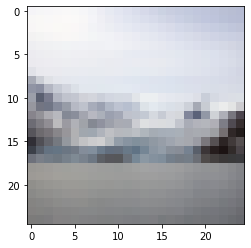

In [11]:
plt.imshow(X_train[2000])
print("La etiqueta es el número: ",y_train[2000])

In [12]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

3000
3000
14034
14034


Usamos otra técnica distinta para mostrar la imagen y ver que pinta tiene.

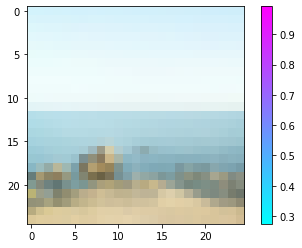

In [13]:
plt.imshow(X_test[0],cmap='cool')
plt.colorbar()

En este caso nuestro algoritmo tendrá que predecir un 4, ya que se corresponde a un mar.

In [14]:
print("La etiqueta es el número: ", y_test[0])

La etiqueta es el número:  4


In [15]:
from skimage.filters import sobel, gaussian

from skimage.exposure import adjust_gamma

Vamos a comparar diferentes transformaciones sobre las imágenes, utilizando la técnica de la corrección del gamma

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


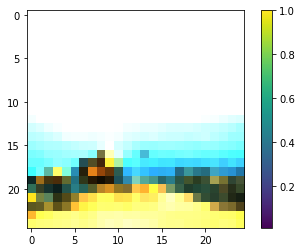

In [16]:
gamma = 4.8 #@param {type: "slider", min:0, max:10, step:0.1}
gain = 4.9 #@param {type: "slider", min:0, max:10, step:0.1}
plt.imshow(adjust_gamma(X_test[0], gamma=gamma, gain=gain))
plt.colorbar()

A continuación vamos a aplicar transformaciones tanto para el train como para el test:

- Blanco y negro: usamos los filtros sobel y gaussian
- Ajuste de exposición tanto para blanco y negro como para color
- Color medio 


In [17]:
X_train_processed = []

for x_ in X_train:
  # color medio (dominante)
  mean_color = np.mean(x_, axis=(0, 1))
  # filtro y conversion a blanco y negro
  filtered_img = sobel(rgb2gray(x_)).flatten() #esto es para blanco y negro + filtro
  filtered_img2 = gaussian(rgb2gray(x_)).flatten()
  exposure_img = adjust_gamma(x_, gamma=gamma, gain=gain).flatten()
  #color_img = x_.flatten()
  X_train_processed.append(np.concatenate([filtered_img, mean_color, exposure_img,filtered_img2]))

X_train_processed = np.vstack(X_train_processed)

X_test_processed = []
for x_ in X_test:
  mean_color = np.mean(x_, axis=(0, 1))
  filtered_img = sobel(rgb2gray(x_)).flatten() #esto es para blanco y negro + filtro
  filtered_img2 = gaussian(rgb2gray(x_)).flatten()
  exposure_img = adjust_gamma(x_, gamma=gamma, gain=gain).flatten()
  #color_img = x_.flatten() # esto es para color
  X_test_processed.append(np.concatenate([filtered_img, mean_color,exposure_img,filtered_img2]))

X_test_processed = np.vstack(X_test_processed)

Por falta de cómputo, nos quedamos con 1/3 de las imágenes originales

In [18]:
# el número en size indica cuántas imágenes se eligen
idx = np.random.choice(len(X_train), size=int(len(X_train)//3), replace=False)

X_train_processed = X_train_processed[idx]
y_train = np.array(y_train)[idx]

In [19]:
print(len(X_train_processed))
print(len(y_train))

print(len(X_test))
print(len(y_test))

1000
1000
14034
14034


## Entrenamiento y validación

Importamos todo lo que nos va a hacer falta

In [20]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import plot_confusion_matrix, confusion_matrix, auc, roc_auc_score, plot_roc_curve, accuracy_score


A continuación, obtenemos los mejores hiperparámetros para cada modelo por separado, para luego utilizarlos dentro de cada ensemble, dependiendo de lo que admita dicho ensemble

* Random Forest

In [21]:
from sklearn.model_selection import GridSearchCV

# Random Forest

parameters_rf = {'n_estimators':[25, 50], 'criterion': ('gini', 'entropy')}
rf = RandomForestClassifier(random_state=1337)
gs_rf = GridSearchCV(rf, parameters_rf)
gs_rf.fit(X_train_processed, y_train)

rf_best_params = gs_rf.best_params_

* SVC

In [22]:
parameters_svc = {'kernel':['linear', 'poly'], 'C': [0.5, 1]}
svc = SVC()
gs_svc = GridSearchCV(svc, parameters_svc, cv=3)
gs_svc.fit(X_train_processed, y_train)

svc_best_params = gs_svc.best_params_

Nos disponemos a hacer el entrenamiento y validación de los diferentes ensembles para clasificación. 



En primer lugar, hacemos un clasificador por votación  ([`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)).

Primero en el apartado de estimators, utilizamos el RandomForestClassifier, el GaussianNB y LogisticRegression.

Y ahora probamos con una configuración `voting='soft'`, que trabaja con las probabilidades de que la muestra pertenezca a una clase en lugar de con la clase directamente. Además, es posible modificar el peso de la probabilidad de cada clasificador mediante el parámetro `weights`, que puede verse más abajo.

A continuación hacemos el GridSearch con lo definido anteriormente con el objetivo de optimizar el hiper-parámetro 

Una vez que tenemos los el hiperparámetro optmizado, entrenamos el modelo con él.

Por último comprobamos que nuestro modelo a predecido la etiqueta de la imagen correctamente, para ello usamos el accuracy_score.

Mostramos por pantalla el resultado final del accuracy y el mejor hiper-parámetro para dicho modelo.

In [23]:
# ------------ 1 voting
rf_clf = RandomForestClassifier(**rf_best_params)
nb_clf = GaussianNB()
lr_clf = LogisticRegression(multi_class='multinomial')

voting_clf = VotingClassifier(
    estimators = [('nb', nb_clf),
                  ('rf', rf_clf),
                  ('lr', lr_clf)],
    voting='soft'
)

voting_parameters = {'weights': [[0.5, 0.25, 0.25],
                                 [0.25, 0.5, 0.25],
                                 [0.25, 0.25, 0.5]]}

voting_gs = GridSearchCV(voting_clf, voting_parameters, cv=3)
voting_gs.fit(X_train_processed, y_train)

y_pred = voting_gs.predict(X_test_processed)
y_pred_proba = voting_gs.predict_proba(X_test_processed)
voting_acc = accuracy_score(y_test, y_pred)
print('ACCURACY', voting_acc)
print('best parameters', voting_gs.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ACCURACY 0.48667521732934305
best parameters {'weights': [0.25, 0.5, 0.25]}


En segundo lugar, hacemos el meta-clasificador [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier).

Primero le pasamos al BaggingClassifier los mejores parámetros obtenidos al haber hecho el gridSearch del SVC y le ponemos la semilla correspondiente de acuerdo al enunciado.

A continuación hacemos el GridSearch con lo definido anteriormente (el hiperparámetro n_estimators), con el objetivo de optimizar los hiperparámetros. 

Una vez que tenemos el hiperparámetro optimizado, entrenamos el modelo con él.

Por último comprobamos que nuestro modelo a predecido la etiqueta de la imagen correctamente, para ello usamos el accuracy_score.

Mostramos por pantalla el resultado final del accuracy y el mejor hiper-parámetro para dicho modelo.

In [24]:
# ------------- 2 bagging 
bagging_clf = BaggingClassifier(base_estimator=SVC(**svc_best_params),
                        random_state=1337)

bagging_parameters = {'n_estimators': [5, 10, 20]}

bagging_gs = GridSearchCV(bagging_clf, bagging_parameters, cv=3)
bagging_gs.fit(X_train_processed, y_train)

y_pred = bagging_gs.predict(X_test_processed)
y_pred_proba = bagging_gs.predict_proba(X_test_processed)
bagging_acc = accuracy_score(y_test, y_pred)
print('ACCURACY', bagging_acc)
print('best parameters', bagging_gs.best_params_)



ACCURACY 0.4746330340601397
best parameters {'n_estimators': 20}


Mostramos que el mejor valor del hiperparámetro n_estimator es 20

<BarContainer object of 3 artists>

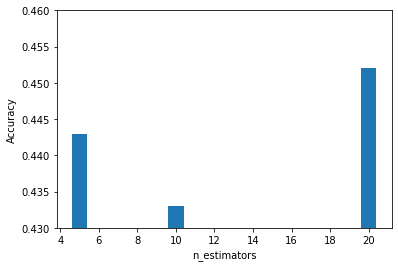

In [33]:
plt.ylim(0.43, 0.46)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.bar(bagging_parameters['n_estimators'], bagging_gs.cv_results_['mean_test_score'])

En tercer lugar, hacemos el clasificador implementado en la clase [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

Primero le pasamos al StackingClassifier los mejores hiper-parámetros obtenidos al haber hecho el gridSearch del SVC y el gridSearch del RandomForestClassifier, además le ponemos la semilla correspondiente de acuerdo al enunciado.

A continuación hacemos el GridSearch con lo definido anteriormente (el hiperparámetro final_estimator), con el objetivo de optimizar el hiperparámetro. 

Una vez que tenemos el hiperparámetro optimizado, entrenamos el modelo con él.

Por último comprobamos que nuestro modelo a predecido la etiqueta de la imagen correctamente, para ello usamos el accuracy_score.

Mostramos por pantalla el resultado final del accuracy y el mejor hiper-parámetro para dicho modelo.

In [26]:
# ------------- 3 stacking
rf_clf_stacking = RandomForestClassifier(random_state=1337, **rf_best_params)
svc_clf_stacking = SVC(**svc_best_params)

stacking_clf = StackingClassifier(
          estimators=[('rf', rf_clf_stacking),
                      ('svc', svc_clf_stacking)],
          final_estimator=LogisticRegression())

stacking_parameters = {'final_estimator': [LogisticRegression(), GaussianNB()]}

stacking_gs = GridSearchCV(stacking_clf, stacking_parameters, cv=3)
stacking_gs.fit(X_train_processed, y_train)

y_pred = stacking_gs.predict(X_test_processed)
y_pred_proba = stacking_gs.predict_proba(X_test_processed)
stacking_acc = accuracy_score(y_test, y_pred)
print('ACCURACY', stacking_acc)
print('best parameters', stacking_gs.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


ACCURACY 0.54282456890409
best parameters {'final_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}


Por último, realizamos el ensemble con la clase [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

Hacemos el GridSearch con lo definido anteriormente (el hiperparámetro n_estimators), con el objetivo de optimizar el hiperparámetro. 

Una vez que tenemos el hiperparámetro optimizado, entrenamos el modelo con él.

Por último comprobamos que nuestro modelo a predecido la etiqueta de la imagen correctamente, para ello usamos el accuracy_score.

Mostramos por pantalla el resultado final del accuracy y el mejor hiper-parámetro para dicho modelo.

In [27]:
#----------------------4 Adabost añadido----------------------------------------
ada_clf = AdaBoostClassifier(random_state=1337)

ada_parameters = {'n_estimators': [25, 30, 50]}

ada_gs = GridSearchCV(ada_clf, ada_parameters, cv=3)
ada_gs.fit(X_train_processed, y_train)

y_pred = ada_gs.predict(X_test_processed)
#y_pred_proba = ada_gs.predict_proba(X_test_processed)
ada_acc = accuracy_score(y_test, y_pred)
print('ACCURACY', ada_acc)
print('best parameters', ada_gs.best_params_)


ACCURACY 0.40936297563061136
best parameters {'n_estimators': 50}


Mostramos que el mejor valor del hiperparámetro n_estimator es 50

<BarContainer object of 3 artists>

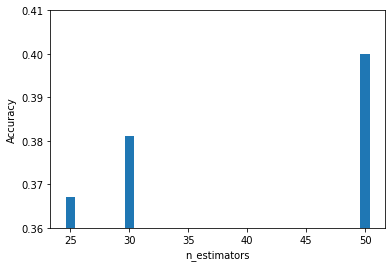

In [36]:
plt.ylim(0.36, 0.41)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.bar(ada_parameters['n_estimators'], ada_gs.cv_results_['mean_test_score'])

## Conclusión Final

Como conclusión podemos decir que usando Stacking es cuando mayor accuracy obtenemos, por lo tanto, es el mejor modelo de ensemble para este caso.

<BarContainer object of 4 artists>

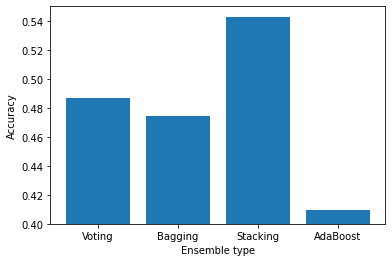

In [39]:
plt.ylim(0.40, 0.55)
plt.ylabel('Accuracy')
plt.xlabel('Ensemble type')
plt.bar(['Voting', 'Bagging', 'Stacking', 'AdaBoost'],
        [voting_acc, bagging_acc, stacking_acc, ada_acc])

In [40]:
stacking_acc

0.54282456890409

Por último también mostramos cuales son los mejores valores del hiperparámetro para el mejor modelo de ensemble que hemos obtenido.

In [31]:
print('best parameters', stacking_gs.best_params_)

best parameters {'final_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}


# Comparativa con diferentes formas de abordar el pre-procesamiento

Este apartado ha sido utilizado para poder elegir la mejor combinación en el pre-procesamiento.

Todas las ejecuciones de este apartado se han hecho con 1/15 de las muestras

El mejor ha sido: 

* Blanco y negro + filtro Sobel, Exposure (gamma = 4.8,gain = 4.9), Mean, Gaussian

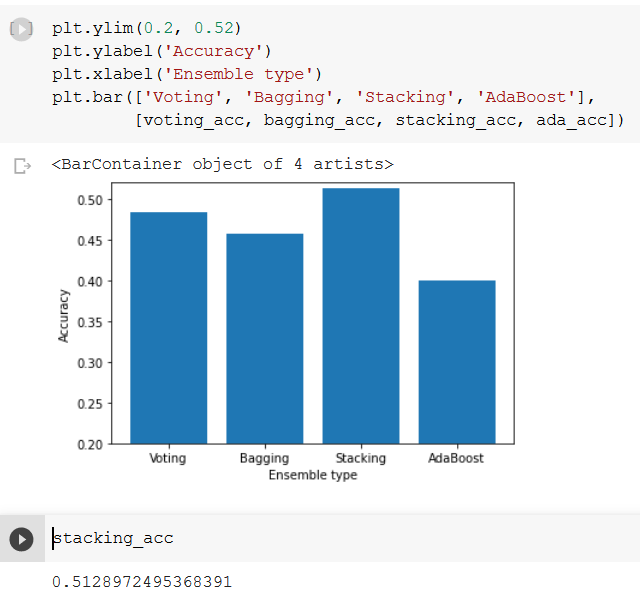

* Utilizando: Blanco y negro + filtro Sobel, Gaussian, Exposure y Mean

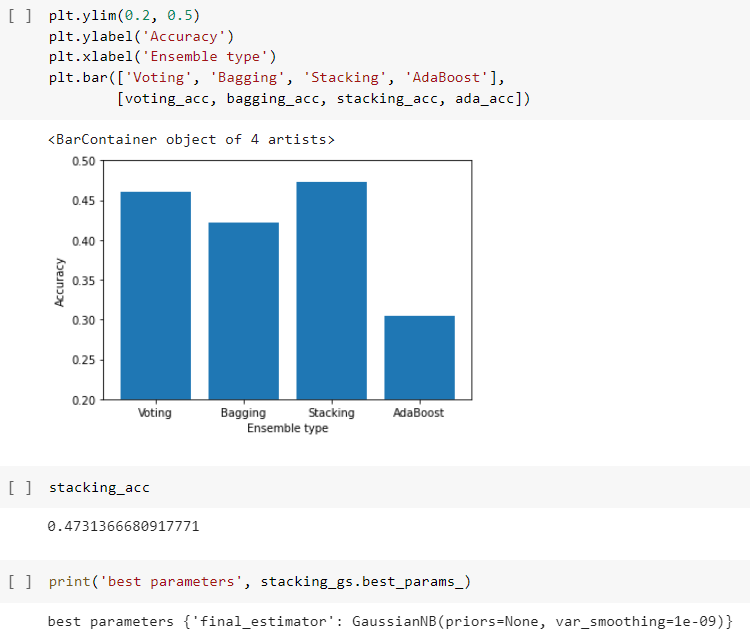

* Utilizando: A color, sin nada más.

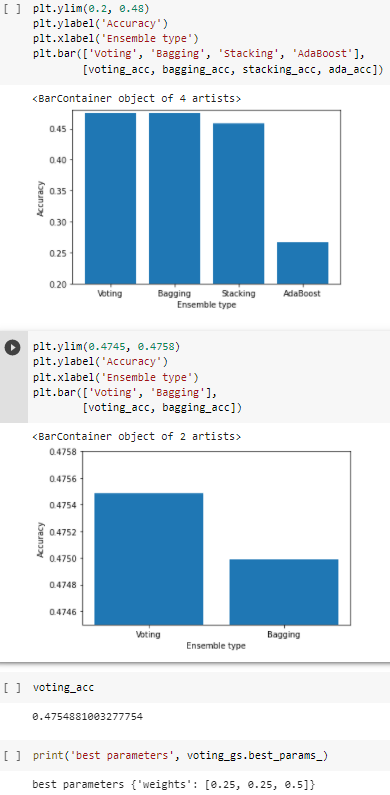

* Utilizando: A color con Mean.

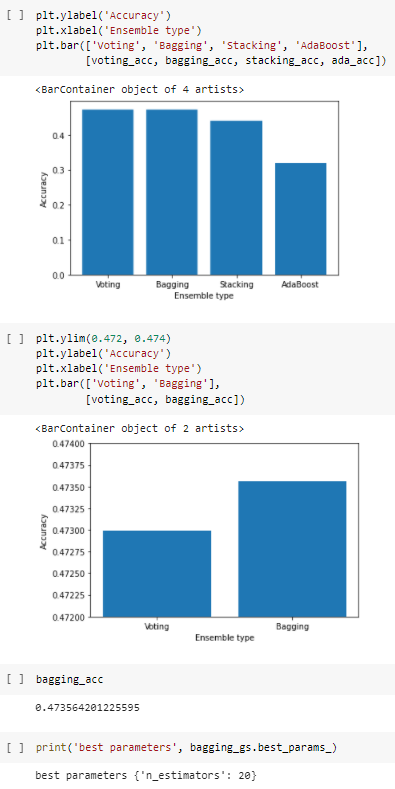

* Utilizando: Blanco y negro + filtro Sobel, Gaussian y Exposure

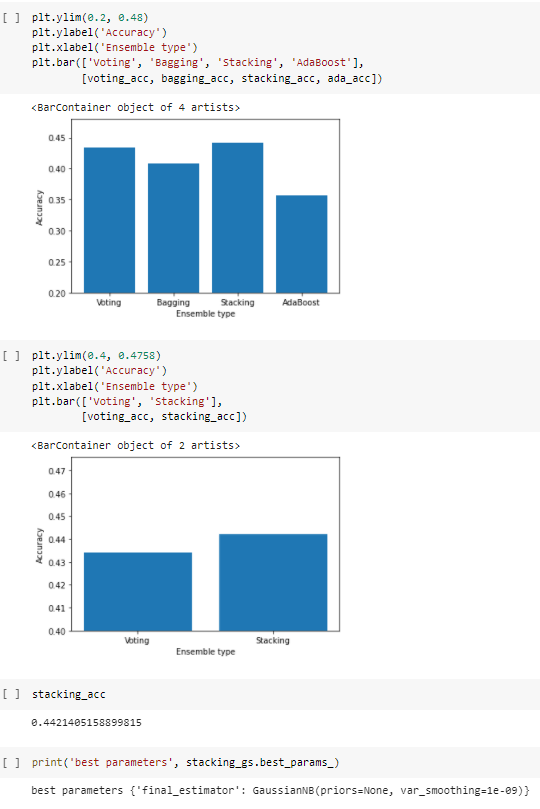

* Utilizando: Color con Exposure y Mean

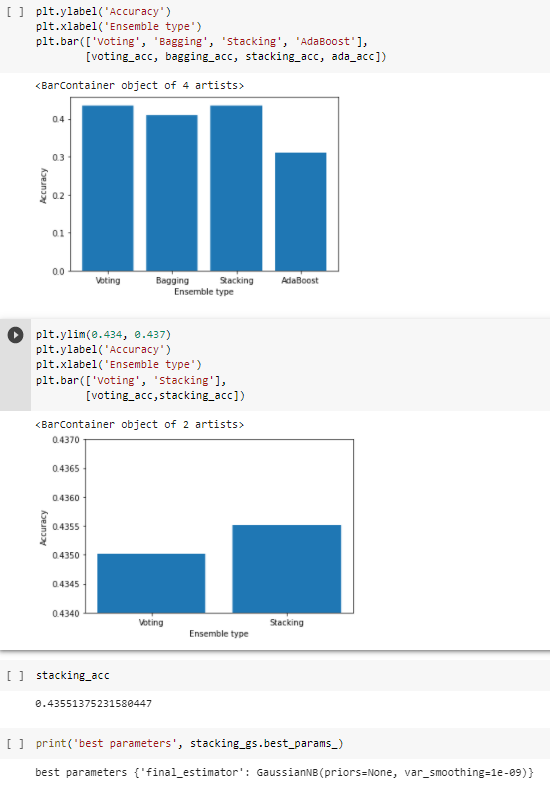

* Utilizando: Blanco y negro + filtro Sobel y Gaussian

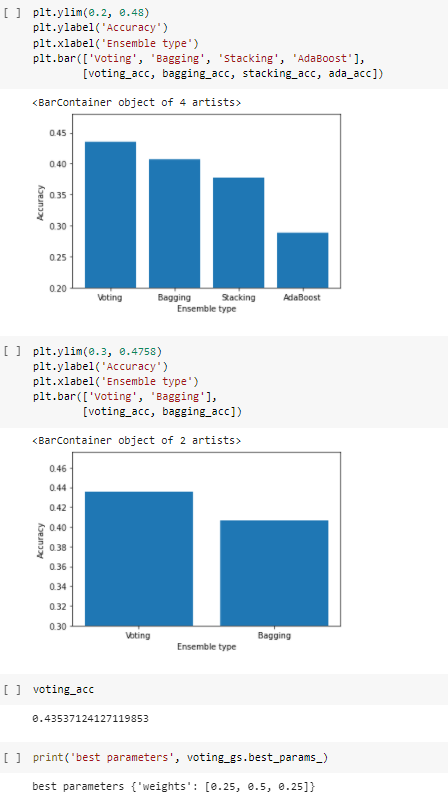

* Utilizando: Blanco y negro, y Gaussian

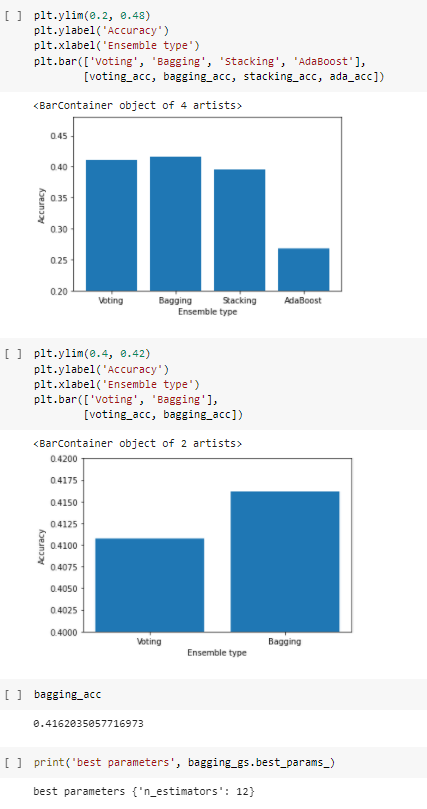

* Utilizando: Sólo Blanco y Negro

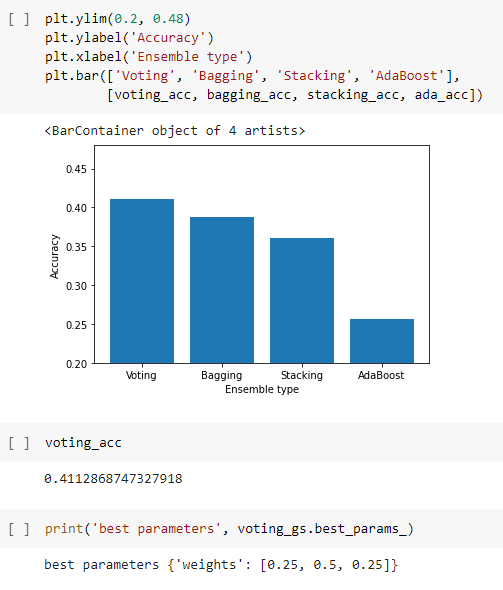

* Utilizando Blanco y Negro + filtro Sobel

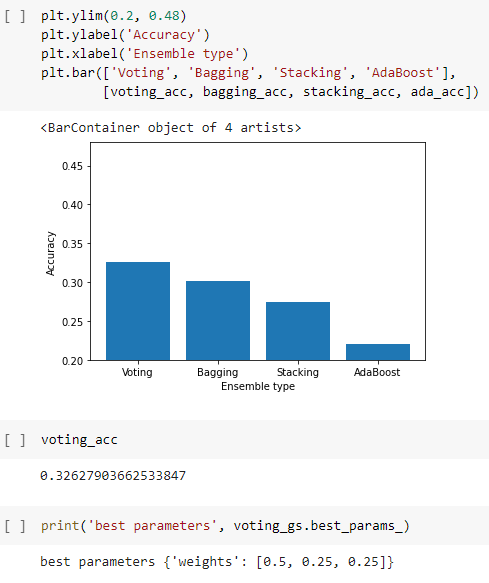

* Utilizando: Color con Exposure

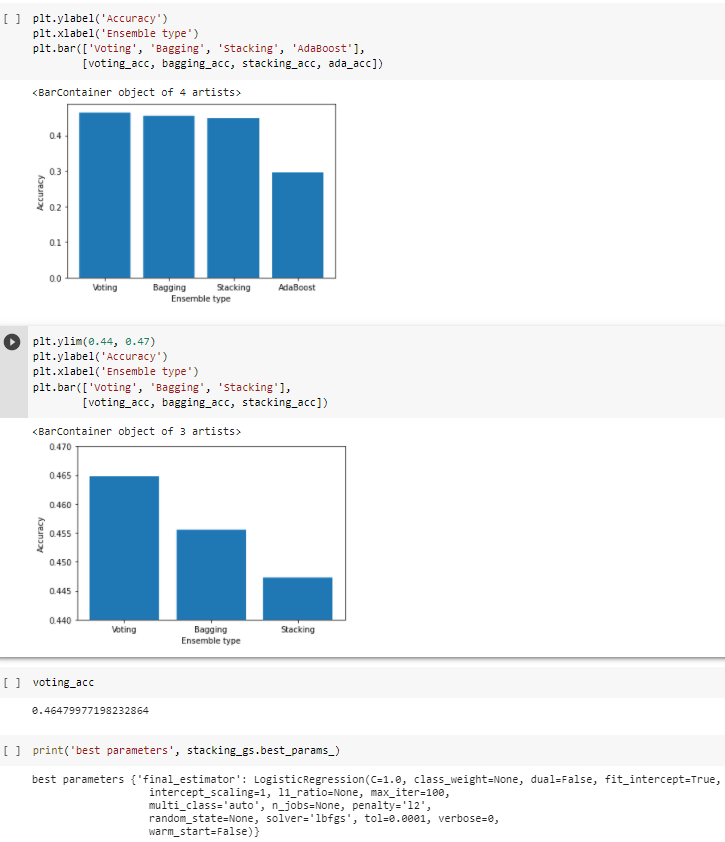

# Enlaces extra


https://docs.python.org/es/3.8/library/zipfile.html#path-objects

http://www.pythondiario.com/2018/08/procesamiento-de-imagenes-con-python-y.html